In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/LoanDataset - LoansDatasest.csv')
df.head(5)

,customer_id,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length,Current_loan_status
0,1.0,22,59000,RENT,123.0,PERSONAL,C,"£35,000.00",16.02,10,Y,3,DEFAULT
1,2.0,21,9600,OWN,5.0,EDUCATION,A,"£1,000.00",11.14,1,NaN,2,NO DEFAULT
2,3.0,25,9600,MORTGAGE,1.0,MEDICAL,B,"£5,500.00",12.87,5,N,3,DEFAULT
3,4.0,23,65500,RENT,4.0,MEDICAL,B,"£35,000.00",15.23,10,N,2,DEFAULT
4,5.0,24,54400,RENT,8.0,MEDICAL,B,"£35,000.00",14.27,10,Y,4,DEFAULT


# Data Cleaning

## Handling Null Values

In [3]:
# count how many null values are present in the dataframe
df.isnull().sum()

,0
customer_id,3
customer_age,0
customer_income,0
home_ownership,0
employment_duration,895
loan_intent,0
loan_grade,0
loan_amnt,1
loan_int_rate,3116
term_years,0


In [4]:
# we can't impute customer_id, and for Current_loan_status, its better to just drop all null values since its only 4 records.
df = df.dropna(subset = ['customer_id'])
df = df.dropna(subset = ['Current_loan_status'])
df.isnull().sum()

,0
customer_id,0
customer_age,0
customer_income,0
home_ownership,0
employment_duration,895
loan_intent,0
loan_grade,0
loan_amnt,1
loan_int_rate,3114
term_years,0


In [5]:
# with a huge amount of missing values in historical_default
# check if its systematic
# looking at the result it shows that the null values in historical_default are an indication of the borrower being new
df[(df['historical_default'].isna()) & (df['Current_loan_status'] == 'NO DEFAULT')].shape[0]

20735

In [6]:
# Add new category in Historical_default called "no_records"
df.loc[(df['historical_default'].isna()) & (df['Current_loan_status'] == 'NO DEFAULT'),
       'historical_default'] = "no_records"

In [7]:
# check result
df.isnull().sum()

,0
customer_id,0
customer_age,0
customer_income,0
home_ownership,0
employment_duration,895
loan_intent,0
loan_grade,0
loan_amnt,1
loan_int_rate,3114
term_years,0


In [8]:
# Imputation using KNN so that it will get its value from the closest records
from sklearn.impute import KNNImputer

# Select Columns to impute
columns_to_impute = ['employment_duration','loan_int_rate']

imputer = KNNImputer(n_neighbors=5)
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])



In [9]:
# Transform the loan_amnt into numerical values without the currency sign
df['loan_amnt'] = df['loan_amnt'].replace('[£,]', '', regex=True).astype(float)
# for the loan amount we will just use mean for imputation
df['loan_amnt'].fillna(df['loan_amnt'].mean(), inplace=True)

/tmp/ipython-input-3520243546.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['loan_amnt'].fillna(df['loan_amnt'].mean(), inplace=True)


In [10]:
df.isna().sum()

,0
customer_id,0
customer_age,0
customer_income,0
home_ownership,0
employment_duration,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
term_years,0


In [11]:
# Check for duplicates
df.duplicated().sum()

np.int64(6)

In [12]:
# Drop duplicates
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [13]:
#check data types
df.dtypes

,0
customer_id,float64
customer_age,int64
customer_income,object
home_ownership,object
employment_duration,float64
loan_intent,object
loan_grade,object
loan_amnt,float64
loan_int_rate,float64
term_years,int64


In [14]:
# Upon inspection customer_income is in string format and have a value "250,000"
# Remove "," and convert string to float
df['customer_income'] = df['customer_income'].replace(',', '', regex=True).astype(float)
df.dtypes

,0
customer_id,float64
customer_age,int64
customer_income,float64
home_ownership,object
employment_duration,float64
loan_intent,object
loan_grade,object
loan_amnt,float64
loan_int_rate,float64
term_years,int64


In [15]:
# Download dataset
from google.colab import files

df.to_csv('loan_predictions.csv', index=False)
files.download('loan_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Loan Default Prediction

## Data Preperation

In [16]:
#create a copy for training the model
df_pred = df

In [17]:
df_pred.head(5)

,customer_id,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length,Current_loan_status
0,1.0,22,59000.0,RENT,123.0,PERSONAL,C,35000.0,16.02,10,Y,3,DEFAULT
1,2.0,21,9600.0,OWN,5.0,EDUCATION,A,1000.0,11.14,1,no_records,2,NO DEFAULT
2,3.0,25,9600.0,MORTGAGE,1.0,MEDICAL,B,5500.0,12.87,5,N,3,DEFAULT
3,4.0,23,65500.0,RENT,4.0,MEDICAL,B,35000.0,15.23,10,N,2,DEFAULT
4,5.0,24,54400.0,RENT,8.0,MEDICAL,B,35000.0,14.27,10,Y,4,DEFAULT


In [18]:
# check each columns' unique values
print(df_pred['home_ownership'].unique())
print("\n",df_pred['loan_intent'].unique())
print("\n",df_pred['loan_grade'].unique())
print("\n",df_pred['historical_default'].unique())
print("\n",df_pred['Current_loan_status'].unique())

['RENT' 'OWN' 'MORTGAGE' 'OTHER']

 ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']

 ['C' 'A' 'B' 'D' 'E']

 ['Y' 'no_records' 'N']

 ['DEFAULT' 'NO DEFAULT']


In [19]:
# Change String values to numerical values for training
df_pred['home_ownership'] = df_pred['home_ownership'].map({'RENT': 0, 'OWN': 1, 'MORTGAGE': 2, 'OTHER': 3})
df_pred['loan_intent'] = df_pred['loan_intent'].map({'PERSONAL': 0, 'EDUCATION': 1, 'MEDICAL': 2, 'VENTURE': 3, 'HOMEIMPROVEMENT': 4, 'DEBTCONSOLIDATION': 5})
df_pred['loan_grade'] = df_pred['loan_grade'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 3})
df_pred['historical_default'] = df_pred['historical_default'].map({'Y': 0, 'no_records': 1, 'N': 2})
df_pred['Current_loan_status'] = df_pred['Current_loan_status'].map({'DEFAULT': 0, 'NO DEFAULT': 1})
df_pred.head(5)

,customer_id,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length,Current_loan_status
0,1.0,22,59000.0,0,123.0,0,2,35000.0,16.02,10,0,3,0
1,2.0,21,9600.0,1,5.0,1,0,1000.0,11.14,1,1,2,1
2,3.0,25,9600.0,2,1.0,2,1,5500.0,12.87,5,2,3,0
3,4.0,23,65500.0,0,4.0,2,1,35000.0,15.23,10,2,2,0
4,5.0,24,54400.0,0,8.0,2,1,35000.0,14.27,10,0,4,0


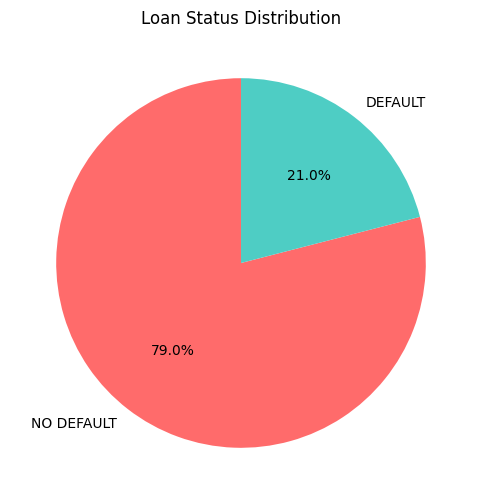

In [20]:
# Check Distribution
labels = {0: 'DEFAULT', 1: 'NO DEFAULT'}
counts = df_pred['Current_loan_status'].map(labels).value_counts()


plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=['#FF6B6B','#4ECDC4'])
plt.title('Loan Status Distribution')
plt.show()

## Model Training

/tmp/ipython-input-2534094690.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_cols] = imputer.fit_transform(X[numeric_cols])


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.76      0.52      0.62      1367
           1       0.88      0.96      0.92      5148

    accuracy                           0.87      6515
   macro avg       0.82      0.74      0.77      6515
weighted avg       0.86      0.87      0.86      6515



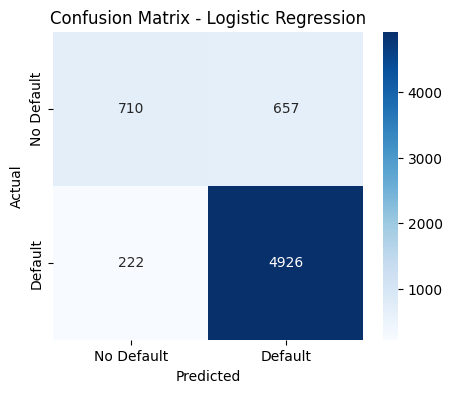



--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1367
           1       0.98      0.97      0.98      5148

    accuracy                           0.96      6515
   macro avg       0.94      0.94      0.94      6515
weighted avg       0.96      0.96      0.96      6515



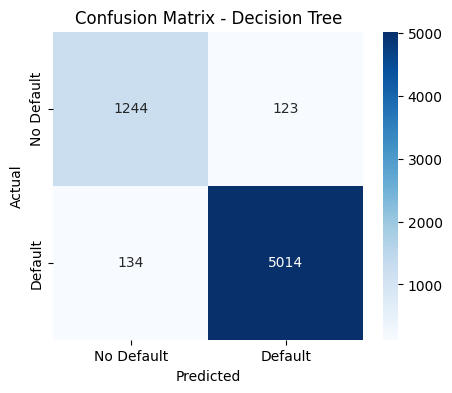



--- Random Forest ---
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1367
           1       0.98      0.99      0.98      5148

    accuracy                           0.97      6515
   macro avg       0.97      0.95      0.96      6515
weighted avg       0.97      0.97      0.97      6515



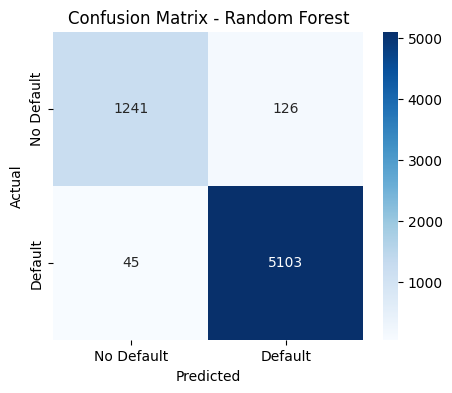



--- KNN ---
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      1367
           1       0.95      0.98      0.96      5148

    accuracy                           0.94      6515
   macro avg       0.93      0.88      0.90      6515
weighted avg       0.94      0.94      0.94      6515



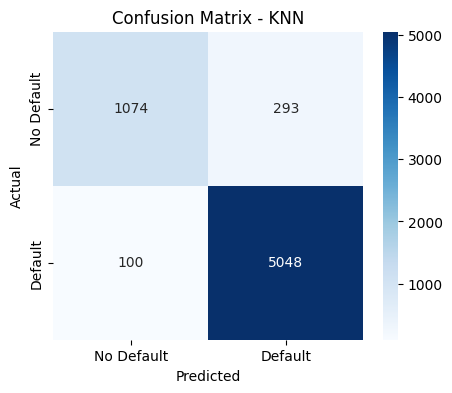



--- SVM ---
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      1367
           1       0.95      0.99      0.97      5148

    accuracy                           0.95      6515
   macro avg       0.95      0.90      0.92      6515
weighted avg       0.95      0.95      0.95      6515



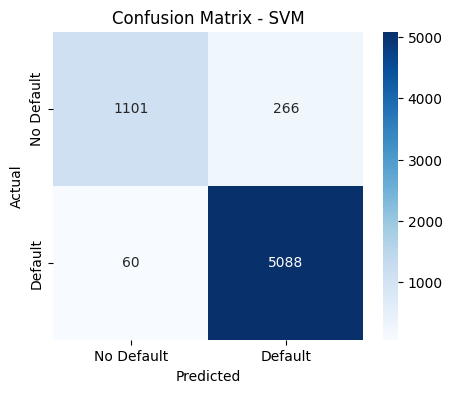

In [21]:
# Train Machine Learning Models with default hyperparameters

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


# Select features and target
features = ['home_ownership', 'loan_intent', 'loan_grade', 'historical_default',
            'customer_age', 'customer_income', 'employment_duration',
            'loan_amnt', 'loan_int_rate', 'term_years', 'cred_hist_length']

target = 'Current_loan_status'

X = df_pred[features]
y = df_pred[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric colmuns for KNN, SVM
numeric_cols = ['customer_age', 'customer_income', 'employment_duration',
                'loan_amnt', 'loan_int_rate', 'term_years', 'cred_hist_length']

imputer = KNNImputer(n_neighbors=5)
X[numeric_cols] = imputer.fit_transform(X[numeric_cols])

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='rbf', probability=True)
}

# Train and evaluate
for name, model in models.items():
    # Use the scaled columns for models that needs it
    if name in ['Logistic Regression', 'KNN', 'SVM']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print("\n")

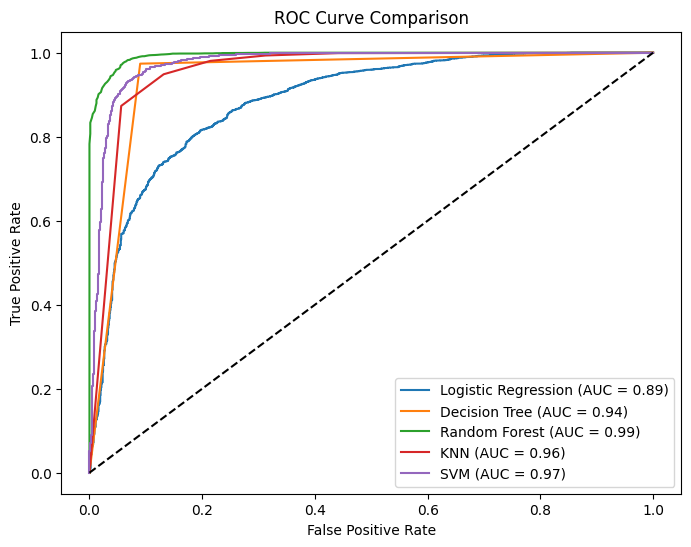

In [22]:
# Get the AUC-ROC curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8,6))

for name, model in models.items():

    if name in ['Logistic Regression', 'KNN', 'SVM']:
        model.fit(X_train_scaled, y_train)
        y_prob = model.predict_proba(X_test_scaled)[:,1]
    else:
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()